In here we'll try to replicate the paper published on ViT **An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale**. Here we will use the already created function to try to smooth the process of replicating this paper.  

In [1]:
# Here we need latest version of torch and torchvision
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

[INFO] torch/torchvision versions not as required, installing nightly versions.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://download.pytorch.org/whl/cu113
torch version: 2.0.0+cu118
torchvision version: 0.15.1+cu118


In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision
from pathlib import Path

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Here we will use the module written as .py file to help us smoothen the process. module help us use dataloaders and ploting.
# also training and testing is also written in these modules
try:
    from setup_plot import *
    from train_test_save import *
except:
    print(f"couldn't find the above mentioned modules. Kindly upload")

[INFO] Couldn't find torchinfo... installing it.


In [3]:
# Making the code device agnostic. Using GPU is recomanded.

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
!!nvidia-smi -L

['GPU 0: Tesla T4 (UUID: GPU-f3353a35-fdff-d6c6-6094-ccdc8e06c155)']

### 1. The Data
Here we will use the the FoodVisionMini dataset, which is pizza, steak and sushi
image dataset. Here we will be using a light dataset to perform and see if we can replicate the paper where this new techinique first came to the whole world.

We'll upload the data from local drive and unzip it. It contains train and test folder with respective images.

In [ ]:
!unzip data.zip

In [5]:
from pathlib import Path
image_path = Path("data/")

In [6]:
image_path# Setup directory paths to train and test images
train_dir = image_path / "pizza_steak_sushi/train"
test_dir = image_path / "pizza_steak_sushi/test"

### 2. Create Datasets and Dataloaders
As we've got our data and setup the directories for each. Now we'll use the create_dataloaders() function in setup_plot.py
First we'll create a transform to perpare our images.

That's where our first references to ViT paper will come, where in table 3 it was mentioned that training resolution is 224X224.

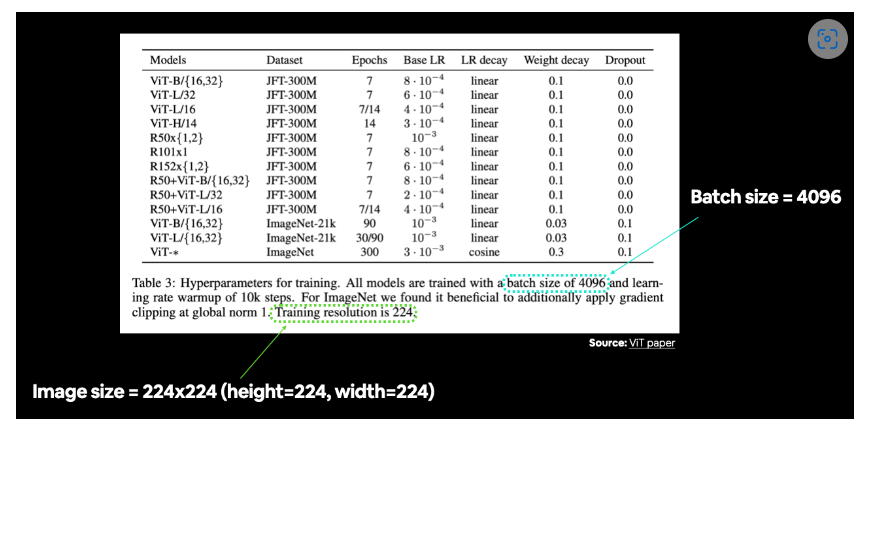

### Creating transforms for images


In [7]:
# Create image size (from Table 3 in the ViT paper) 
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])           
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
)


### Turn images in dataloader's
Transforms are created. Now's let's create our data loader's. 
Here we'll stick to our batch size of 32 as batch size mentioned in paper(4096) is infeasible for us to perform in colab.
Having a batch size of 4096 that 4096 images needs to fit into the GPU memory at a time.

**Note**: We're using the pin_memory=True parameter in the create_dataloaders() function to speed up computation. pin_memory=True avoids unnecessary copying of memory between the CPU and GPU memory by "pinning" examples that have been seen before. Though the benefits of this will likely be seen with larger dataset sizes (our FoodVision Mini dataset is quite small).

In [8]:
# Set the batch size
BATCH_SIZE = 32 # this is lower than the ViT paper but it's because we're starting small

# Create data loaders
train_dataloader, test_dataloader, class_names = create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, # use manually created transforms
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7f2510262ac0>,
 ['pizza', 'steak', 'sushi'])

### 2.3 Visualize the image
As we've loaded our data now is the time to visualize the images to see how they look.
So, let's get a single image and label from a batch of data and inspect their shapes.

In [ ]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(1))

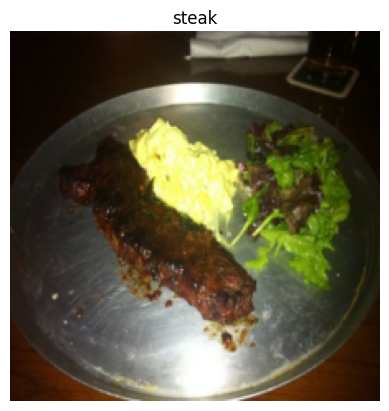

In [ ]:
# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False);

### 3. Starting with paper: an overview
Here we're trying to replicate the ViT paper for our problem FoodVisionMini dataset.

so our model inputs are: images of pizza, steak and sushi.

And our ideal model outputs are: predicted labels of pizza, steak or sushi.


### layers and blocks
ViT is a deep learning neural network architecture.

And any neural network architecture is generally comprised of layers.

And a collection of layers is often referred to as a block.

And stacking many blocks together is what gives us the whole architecture.

A layer takes an input (say an image tensor), performs some kind of function on it (for example what's in the layer's forward() method) and then returns an output.

So if a single layer takes an input and gives an output, then a collection of layers or a block also takes an input and gives an output.

Let's solidify the learning:
- Layer - takes an input, performs a function on it, returns an output.
- Block - a collection of layers, takes an input, performs a series of functions on it, returns an output.
- Architecture (or model) - a collection of blocks, takes an input, performs a series of functions on it, returns an output.
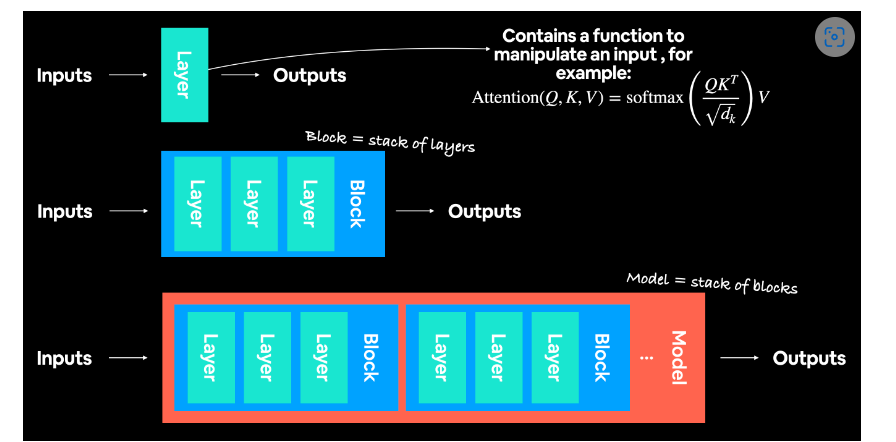

### Getting specific about the paper.
What will we use and how will we perform the implementation.
- 1. **Figure1** - The overview of the model in graphical sense. It is self explanatory and we can creat whole architecture from that alone.
- 2. **section3.1** - Mathematical equations for more insights
-3. **Table1** - This table shows various hyperparameter setting. For now're focused on the ViT-base.

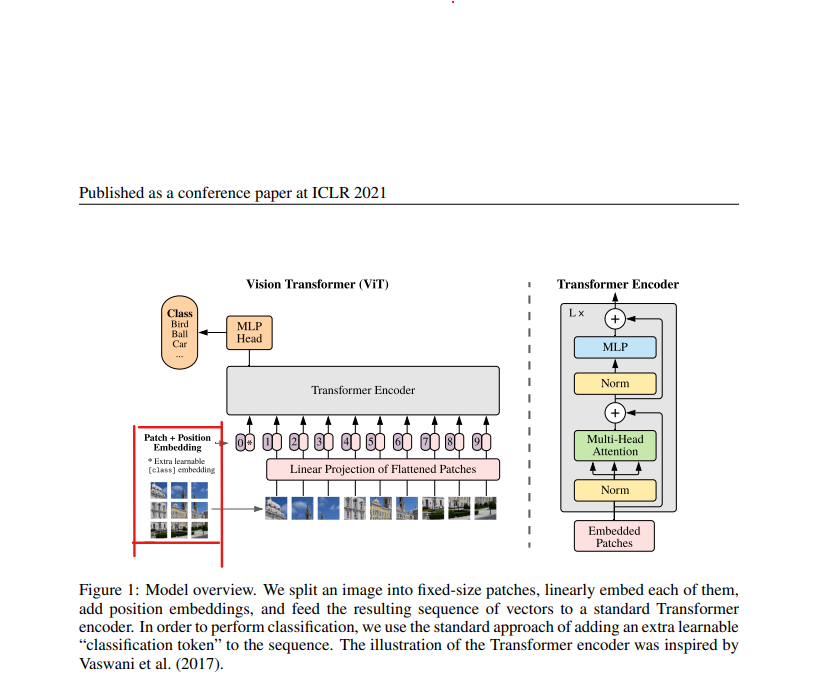

The main equations

image.png

Here is the table 1

image.png

### 4. Split data into patches and create embedding
We will create embedding of patches it will represent the data in a good learnable way, chances are the learning algorithms will perform well on them.
We'll start with **Patch embedding**.\
This mean that we'll be turning out input images in a sequence of patches and then embedding those patches.\
As we know that embedding is a learnable representation of some form and is often a vector.

Let's start by calculating the input and output shapes by hand.



In [ ]:
# Create example values
height = 224 # H 
width = 224 # W
color_channels = 3 # C
patch_size = 16 # P

# Calculate N (number of patches)
number_of_patches = int((height * width) / patch_size**2)
print(f"Number of patches (N) with image height (H={height}), width (W={width}) and patch size (P={patch_size}): {number_of_patches}")

Number of patches (N) with image height (H=224), width (W=224) and patch size (P=16): 196


In [ ]:
# Input shape (this is the size of a single image)
embedding_layer_input_shape = (height, width, color_channels)

# Output shape
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)

print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (single 2D image flattened into patches): {embedding_layer_output_shape}")

Input shape (single 2D image): (224, 224, 3)
Output shape (single 2D image flattened into patches): (196, 768)


### Turning a single image into patches
So as know now the ideal input and output shapes for out **patch embedding** layer, let's move towards making it.
Let's turn our single image into patches

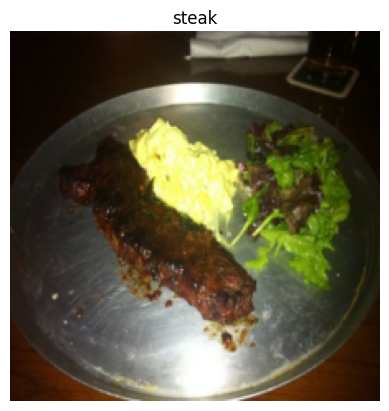

In [ ]:
# View single image
plt.imshow(image.permute(1, 2, 0)) # adjust for matplotlib
plt.title(class_names[label])
plt.axis(False);

In [ ]:
# Change image shape to be compatible with matplotlib (color_channels, height, width) -> (height, width, color_channels) 
image_permuted = image.permute(1, 2, 0)

# Index to plot the top row of patched pixels(visualize)
patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :]);

Turning the top row into patches.

In [ ]:
# Setup hyperparameters and make sure img_size and patch_size are compatible
img_size = 224
patch_size = 16
num_patches = img_size/patch_size 
assert img_size % patch_size == 0, "Image size must be divisible by patch size" 
print(f"Number of patches per row: {num_patches}\nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows=1, 
                        ncols=img_size // patch_size, # one column for each patch
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Iterate through number of patches in the top row
for i, patch in enumerate(range(0, img_size, patch_size)):
    axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :]); # keep height index constant, alter the width index
    axs[i].set_xlabel(i+1) # set the label
    axs[i].set_xticks([])
    axs[i].set_yticks([])

Number of patches per row: 14.0
Patch size: 16 pixels x 16 pixels


This looks good let's iterate it over through the whole image.


In [ ]:

img_size = 224
patch_size = 16
num_patches = img_size/patch_size 
assert img_size % patch_size == 0, "Image size must be divisible by patch size" 
print(f"Number of patches per row: {num_patches}\
        \nNumber of patches per column: {num_patches}\
        \nTotal patches: {num_patches*num_patches}\
        \nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows=img_size // patch_size, # need int not float
                        ncols=img_size // patch_size, 
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Loop through height and width of image
for i, patch_height in enumerate(range(0, img_size, patch_size)): # iterate through height
    for j, patch_width in enumerate(range(0, img_size, patch_size)): # iterate through width
        
        # Plot the permuted image patch (image_permuted -> (Height, Width, Color Channels))
        axs[i, j].imshow(image_permuted[patch_height:patch_height+patch_size, # iterate through height 
                                        patch_width:patch_width+patch_size, # iterate through width
                                        :]) # get all color channels
        
        # Set up label information, remove the ticks for clarity and set labels to outside
        axs[i, j].set_ylabel(i+1, 
                             rotation="horizontal", 
                             horizontalalignment="right", 
                             verticalalignment="center") 
        axs[i, j].set_xlabel(j+1) 
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].label_outer()

# Set a super title
fig.suptitle(f"{class_names[label]} -> Patchified", fontsize=16)
plt.show()

Number of patches per row: 14.0        
Number of patches per column: 14.0        
Total patches: 196.0        
Patch size: 16 pixels x 16 pixels


This is just for demonstation here we'll creates patches with convultion.

Now we have to turn each of these patches into embeddings and covert them into a sequence for that we'll use PyTorch layers.
We'll use **torch.nn.Conv2d()**.\
By setting the **kernel_size** and **stride** parameter of Conv2d layer equal to 16 , we can effectively get layer that splits our images into patches and create a learnable embedding.\
As we know:\
**Input**: 2D image with size **H x W x C**.
**Output**: The image gets converted to a sequence of flattened 2D patches with size **N x (Psquared.C)**.




In [ ]:
from torch import nn

# Set the patch size
patch_size=16

# Create the Conv2d layer with hyperparameters from the ViT paper
conv2d = nn.Conv2d(in_channels=3, # number of color channels
                   out_channels=768, # from Table 1: Hidden size D, this is the embedding size
                   kernel_size=patch_size, # could also use (patch_size, patch_size)
                   stride=patch_size,
                   padding=0)

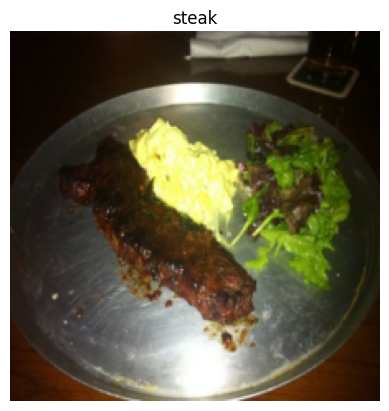

In [ ]:
# View single image
plt.imshow(image.permute(1, 2, 0)) # adjust for matplotlib
plt.title(class_names[label])
plt.axis(False);

In [ ]:
# Pass the image through the convolutional layer 
image_out_of_conv = conv2d(image.unsqueeze(0)) # add a single batch dimension (height, width, color_channels) -> (batch, height, width, color_channels)
print(image_out_of_conv.shape)

torch.Size([1, 768, 14, 14])


Passing our image through conv layer turns it into the series of 768(embedding size D) feature maps.

Let's visualize 5 random features maps and what they looks like.

Showing random convolutional feature maps from indexes: [161, 601, 44, 257, 150]


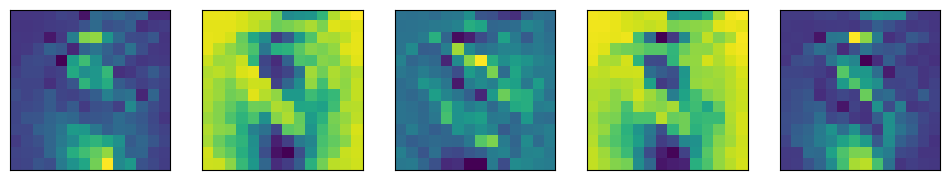

In [ ]:
# Plot random 5 convolutional feature maps
import random
random_indexes = random.sample(range(0, 758), k=5) # pick 5 numbers between 0 and the embedding size
print(f"Showing random convolutional feature maps from indexes: {random_indexes}")

# Create plot
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 12))

# Plot random image feature maps
for i, idx in enumerate(random_indexes):
    image_conv_feature_map = image_out_of_conv[:, idx, :, :] # index on the output tensor of the convolutional layer
    axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
    axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[]);

These features maps seems to represent the original image.
These features may change over times as NN learns.
Because of this, these features maps can be considered a **learnable embedding** of our image.


In [ ]:
# # Get a single feature map in tensor form
# single_feature_map = image_out_of_conv[:, 0, :, :]
# single_feature_map, single_feature_map.requires_grad

In [ ]:
# Current tensor shape
print(f"Current tensor shape: {image_out_of_conv.shape} -> [batch, embedding_dim, feature_map_height, feature_map_width]")

Current tensor shape: torch.Size([1, 768, 14, 14]) -> [batch, embedding_dim, feature_map_height, feature_map_width]


Flattening the patch embedding but they still are in 2D. we need 1D sequence of patch embedding let's use torch.nn.Flatten

In [ ]:
# Create flatten layer
flatten = nn.Flatten(start_dim=2, # flatten feature_map_height (dimension 2)
                     end_dim=3) # flatten feature_map_width (dimension 3)

Original image shape: torch.Size([3, 224, 224])
Image feature map shape: torch.Size([1, 768, 14, 14])
Flattened image feature map shape: torch.Size([1, 768, 196])


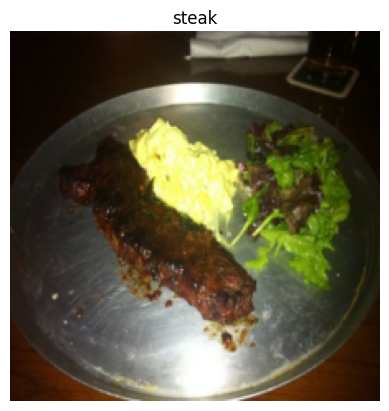

In [ ]:
# 1. View single image
plt.imshow(image.permute(1, 2, 0)) # adjust for matplotlib
plt.title(class_names[label])
plt.axis(False);
print(f"Original image shape: {image.shape}")

# 2. Turn image into feature maps
image_out_of_conv = conv2d(image.unsqueeze(0)) # add batch dimension to avoid shape errors
print(f"Image feature map shape: {image_out_of_conv.shape}")

# 3. Flatten the feature maps
image_out_of_conv_flattened = flatten(image_out_of_conv)
print(f"Flattened image feature map shape: {image_out_of_conv_flattened.shape}")

In [ ]:
# Get flattened image patch embeddings in right shape 
image_out_of_conv_flattened_reshaped = image_out_of_conv_flattened.permute(0, 2, 1) # [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]
print(f"Patch embedding sequence shape: {image_out_of_conv_flattened_reshaped.shape} -> [batch_size, num_patches, embedding_size]")

Patch embedding sequence shape: torch.Size([1, 196, 768]) -> [batch_size, num_patches, embedding_size]


let's visualize one of feature maps with 1D flattened sequence


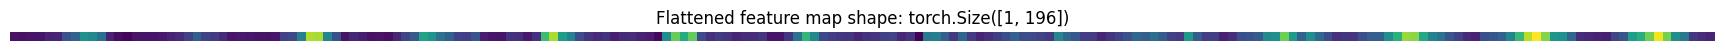

In [ ]:
# Get a single flattened feature map
single_flattened_feature_map = image_out_of_conv_flattened_reshaped[:, :, 0] # index: (batch_size, number_of_patches, embedding_dimension)

# Plot the flattened feature map visually
plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False);

In [ ]:
# See the flattened feature map as a tensor
single_flattened_feature_map, single_flattened_feature_map.requires_grad, single_flattened_feature_map.shape

(tensor([[-4.6357e-03, -5.6798e-03, -2.7334e-03, -9.2403e-04,  2.2179e-02,
           2.8245e-02,  1.2236e-01,  1.6566e-01,  2.8468e-01,  2.6186e-01,
           1.9197e-01,  2.3441e-02, -1.3380e-02, -2.6842e-02, -3.7912e-03,
          -2.3694e-03, -2.5793e-03,  5.1724e-03,  2.4914e-02,  3.8455e-02,
           8.6762e-02,  1.5363e-01,  9.2409e-02,  7.2590e-02,  4.0575e-02,
           1.3642e-03,  8.7656e-03,  3.5348e-03, -2.0433e-03, -3.9027e-03,
           2.4507e-03,  9.0832e-02,  1.0188e-01,  2.3651e-01,  5.1761e-01,
           5.0988e-01,  2.5426e-01,  1.2205e-01, -4.9888e-03,  3.0781e-02,
           1.6131e-02, -7.0922e-03, -4.6848e-03, -1.1141e-02,  3.0996e-02,
           9.3131e-02,  1.3879e-01,  3.2980e-01,  2.9000e-01,  1.9862e-01,
           1.5056e-01,  8.9941e-02,  7.6317e-02,  1.2606e-01,  1.2827e-02,
           5.1671e-04, -4.5393e-03,  5.3932e-02,  5.0145e-02,  8.5028e-03,
           5.2168e-02,  3.9619e-01,  5.1298e-01,  3.1496e-01,  2.4009e-01,
           1.1296e-01,  5

### Turning ViT patch embedding into a PyTorch Module
We can do so by subclassing nn.Module and creating a small PyTorch "model" to do all of the steps above.

In [ ]:
# 1. Create a class which subclasses nn.Module
class PatchEmbedding(nn.Module):
    """Turns a 2D input image into a 1D sequence learnable embedding vector.
    
    Args:
        in_channels (int): Number of color channels for the input images. Defaults to 3.
        patch_size (int): Size of patches to convert input image into. Defaults to 16.
        embedding_dim (int): Size of embedding to turn image into. Defaults to 768.
    """ 
    # 2. Initialize the class with appropriate variables
    def __init__(self, 
                 in_channels:int=3,
                 patch_size:int=16,
                 embedding_dim:int=768):
        super().__init__()
        
        # 3. Create a layer to turn an image into patches
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)

        # 4. Create a layer to flatten the patch feature maps into a single dimension
        self.flatten = nn.Flatten(start_dim=2, # only flatten the feature map dimensions into a single vector
                                  end_dim=3)

    # 5. Define the forward method 
    def forward(self, x):
        # Create assertion to check that inputs are the correct shape
        image_resolution = x.shape[-1]
        assert image_resolution % patch_size == 0, f"Input image size must be divisble by patch size, image shape: {image_resolution}, patch size: {patch_size}"
        
        # Perform the forward pass
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched) 
        # 6. Make sure the output shape has the right order 
        return x_flattened.permute(0, 2, 1) # adjust so the embedding is on the final dimension [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]

Trying above class on a single image


In [ ]:
torch.cuda.manual_seed(42)

# Create an instance of patch embedding layer
patchify = PatchEmbedding(in_channels=3,
                          patch_size=16,
                          embedding_dim=768)

# Pass a single image through
print(f"Input image shape: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0)) # add an extra batch dimension on the 0th index, otherwise will error
print(f"Output patch embedding shape: {patch_embedded_image.shape}")

Input image shape: torch.Size([1, 3, 224, 224])
Output patch embedding shape: torch.Size([1, 196, 768])


That worked great, our input and output shape matches with what is mentioned in paper.
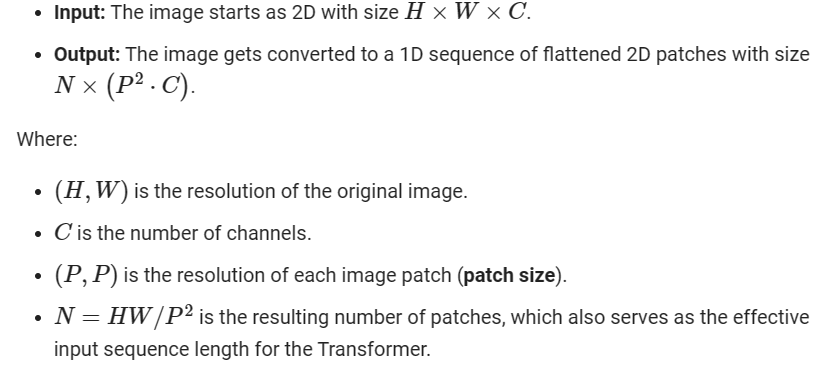

In [ ]:
# Create random input sizes
random_image = (1, 3, 224, 224)

# Get a summary of the input and outputs of PatchEmbedding
summary(PatchEmbedding(), 
        input_size=random_image,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

/usr/local/lib/python3.9/dist-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
/usr/local/lib/python3.9/dist-packages/torch/storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
PatchEmbedding (PatchEmbedding)          [1, 3, 224, 224]     [1, 196, 768]        --                   True
├─Conv2d (patcher)                       [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
├─Flatten (flatten)                      [1, 768, 14, 14]     [1, 768, 196]        --                   --
Total params: 590,592
Trainable params: 590,592
Non-trainable params: 0
Total mult-adds (M): 115.76
Input size (MB): 0.60
Forward/backward pass size (MB): 1.20
Params size (MB): 2.36
Estimated Total Size (MB): 4.17

In [ ]:
# View the patch embedding and patch embedding shape
print(patch_embedded_image) 
print(f"Patch embedding shape: {patch_embedded_image.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[-0.0095, -0.0154, -0.0090,  ..., -0.0034,  0.0282, -0.0043],
         [-0.0096, -0.0194, -0.0078,  ..., -0.0061,  0.0281, -0.0021],
         [-0.0111, -0.0244, -0.0129,  ..., -0.0098,  0.0266, -0.0126],
         ...,
         [ 0.0373, -0.1326, -0.0133,  ..., -0.0482, -0.0305, -0.1517],
         [ 0.0159, -0.0816, -0.0122,  ..., -0.0380, -0.0011, -0.0996],
         [-0.0053, -0.0560, -0.0106,  ..., -0.0188,  0.0117, -0.0534]]],
       grad_fn=<PermuteBackward0>)
Patch embedding shape: torch.Size([1, 196, 768]) -> [batch_size, number_of_patches, embedding_dimension]


### Class token embedding
Now, we have to create a class token embedding which is a learnable embedding and we need to "preprend a learnable embedding to the sequence of embedded patches".

In [ ]:
# Get the batch size and embedding dimension
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]

# Create the class token embedding as a learnable parameter that shares the same size as the embedding dimension (D)
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension), # [batch_size, number_of_tokens, embedding_dimension]
                           requires_grad=True) # make sure the embedding is learnable

# Show the first 10 examples of the class_token
print(class_token[:, :, :10])

# Print the class_token shape
print(f"Class token shape: {class_token.shape} -> [batch_size, number_of_tokens, embedding_dimension]")

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
Class token shape: torch.Size([1, 1, 768]) -> [batch_size, number_of_tokens, embedding_dimension]


In [ ]:
# Add the class token embedding to the front of the patch embedding
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image), 
                                                      dim=1) # concat on first dimension

# Print the sequence of patch embeddings with the prepended class token embedding
print(patch_embedded_image_with_class_embedding)
print(f"Sequence of patch embeddings with class token prepended shape: {patch_embedded_image_with_class_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.0095, -0.0154, -0.0090,  ..., -0.0034,  0.0282, -0.0043],
         [-0.0096, -0.0194, -0.0078,  ..., -0.0061,  0.0281, -0.0021],
         ...,
         [ 0.0373, -0.1326, -0.0133,  ..., -0.0482, -0.0305, -0.1517],
         [ 0.0159, -0.0816, -0.0122,  ..., -0.0380, -0.0011, -0.0996],
         [-0.0053, -0.0560, -0.0106,  ..., -0.0188,  0.0117, -0.0534]]],
       grad_fn=<CatBackward0>)
Sequence of patch embeddings with class token prepended shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


In [ ]:
# View the sequence of patch embeddings with the prepended class embedding
patch_embedded_image_with_class_embedding, patch_embedded_image_with_class_embedding.shape

(tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [-0.0095, -0.0154, -0.0090,  ..., -0.0034,  0.0282, -0.0043],
          [-0.0096, -0.0194, -0.0078,  ..., -0.0061,  0.0281, -0.0021],
          ...,
          [ 0.0373, -0.1326, -0.0133,  ..., -0.0482, -0.0305, -0.1517],
          [ 0.0159, -0.0816, -0.0122,  ..., -0.0380, -0.0011, -0.0996],
          [-0.0053, -0.0560, -0.0106,  ..., -0.0188,  0.0117, -0.0534]]],
        grad_fn=<CatBackward0>),
 torch.Size([1, 197, 768]))

### Positional embeddings
Position embeddings are added to the patch embeddings to retain positional information. We use standard learnable 1D position embeddings, since we have not observed significant performance gains from using more advanced 2D-aware position embeddings (Appendix D.4). The resulting sequence of embedding vectors serves as input to the encoder.

By "retain information" the authors meant the order the patches came in. like the patch 3 come in before pacth 2. 
This positional information is important considering the image, without it a flattened sequence could be seen as having no order and thus doesn't relate to any patch.

our current embedding are of shape([1, 197, 768])

Equation from paper states position embeddings should have the shape:
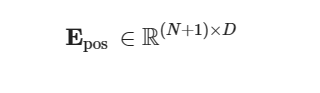

In [ ]:
# View the sequence of patch embeddings with the prepended class embedding
patch_embedded_image_with_class_embedding, patch_embedded_image_with_class_embedding.shape

(tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [-0.0095, -0.0154, -0.0090,  ..., -0.0034,  0.0282, -0.0043],
          [-0.0096, -0.0194, -0.0078,  ..., -0.0061,  0.0281, -0.0021],
          ...,
          [ 0.0373, -0.1326, -0.0133,  ..., -0.0482, -0.0305, -0.1517],
          [ 0.0159, -0.0816, -0.0122,  ..., -0.0380, -0.0011, -0.0996],
          [-0.0053, -0.0560, -0.0106,  ..., -0.0188,  0.0117, -0.0534]]],
        grad_fn=<CatBackward0>),
 torch.Size([1, 197, 768]))

In [ ]:
# Calculate N (number of patches)
number_of_patches = int((height * width) / patch_size**2)
# Get embedding dimension
embedding_dimension = patch_embedded_image_with_class_embedding.shape[2]

# Create the learnable 1D position embedding
position_embedding = nn.Parameter(torch.ones(1,
                                             number_of_patches+1, 
                                             embedding_dimension),
                                  requires_grad=True) # make sure it's learnable

# Show the first 10 sequences and 10 position embedding values and check the shape of the position embedding
print(position_embedding[:, :10, :10])
print(f"Position embeddding shape: {position_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
Position embeddding shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


Postional embeddings created, let's add them to our sequence of patch embeddings with a prepend class token.

In [ ]:
# Add the position embedding to the patch and class token embedding
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
print(patch_and_position_embedding)
print(f"Patch embeddings, class token prepended and positional embeddings added shape: {patch_and_position_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.9905, 0.9846, 0.9910,  ..., 0.9966, 1.0282, 0.9957],
         [0.9904, 0.9806, 0.9922,  ..., 0.9939, 1.0281, 0.9979],
         ...,
         [1.0373, 0.8674, 0.9867,  ..., 0.9518, 0.9695, 0.8483],
         [1.0159, 0.9184, 0.9878,  ..., 0.9620, 0.9989, 0.9004],
         [0.9947, 0.9440, 0.9894,  ..., 0.9812, 1.0117, 0.9466]]],
       grad_fn=<AddBackward0>)
Patch embeddings, class token prepended and positional embeddings added shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


### Putting it together from image to embedding

In [ ]:
torch.cuda.manual_seed(42)

# 1. Set patch size
patch_size = 16

# 2. Print shape of original image tensor and get the image dimensions
print(f"Image tensor shape: {image.shape}")
height, width = image.shape[1], image.shape[2]

# 3. Get image tensor and add batch dimension
x = image.unsqueeze(0)
print(f"Input image with batch dimension shape: {x.shape}")

# 4. Create patch embedding layer
patch_embedding_layer = PatchEmbedding(in_channels=3,
                                       patch_size=patch_size,
                                       embedding_dim=768)

# 5. Pass image through patch embedding layer
patch_embedding = patch_embedding_layer(x)
print(f"Patching embedding shape: {patch_embedding.shape}")

# 6. Create class token embedding
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True) # make sure it's learnable
print(f"Class token embedding shape: {class_token.shape}")

# 7. Prepend class token embedding to patch embedding
patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f"Patch embedding with class token shape: {patch_embedding_class_token.shape}")

# 8. Create position embedding
number_of_patches = int((height * width) / patch_size**2)
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension),
                                  requires_grad=True) # make sure it's learnable

# 9. Add position embedding to patch embedding with class token
patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")

Image tensor shape: torch.Size([3, 224, 224])
Input image with batch dimension shape: torch.Size([1, 3, 224, 224])
Patching embedding shape: torch.Size([1, 196, 768])
Class token embedding shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768])


### 5. Multi-Head-Attention(MSA)
Now, let's move on to the next part of ViT architecture.

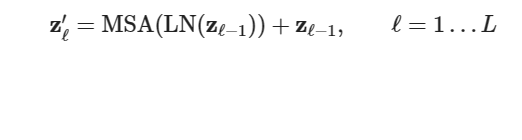

This equation indicate MSA layer wrapped in LayerNorm(LN) with a residual connection

**LayerNorm(LN)** **Layer**
layer normalization (torch.nn.LayerNorm()) normalized an input over the last dimension. Its main parameter is normalized_shape which can be set in our case to Dimension size 768.\
LN help improves the training and model generalization.

**Multi-Head** **Self Attention(MSA)** **layer**

This was originally designed for text inputs. original self-attention mechanism takes a sequence of words and then calculates which word should pay more "attention" to another word.\
Since our input is a sequence of image patches rather than words, self-attention and in turn multi-head attention will calculate which patch of an image is most related to another patch, eventually forming a learned representation of an image.

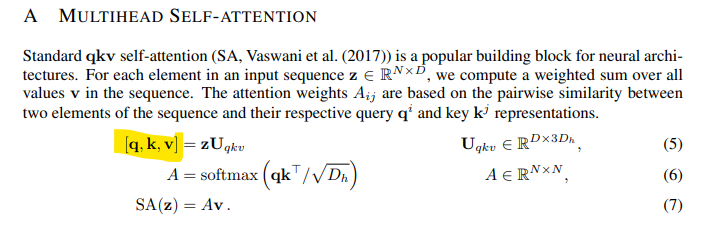

Teh image above highlists the triple embedding input to the MSA layer.

This is knows as **query**, **key**, **value** input or **qkv** for short.
In our case triple embedding ipupt will be three versions of the output of LN.

In [ ]:
# 1. Create a class that inherits from nn.Module
class MultiheadSelfAttentionBlock(nn.Module):
    """Creates a multi-head self-attention block ("MSA block" for short).
    """
    # 2. Initialize the class with hyperparameters from Table 1
    def __init__(self,
                 embedding_dim:int=768, # D
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 attn_dropout:float=0): 
        super().__init__()
        
        # 3. Create the Norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        
        # 4. Create the Multi-Head Attention (MSA) layer
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                    num_heads=num_heads,
                                                    dropout=attn_dropout,
                                                    batch_first=True) # does our batch dimension come first?
        
    # 5. Create a forward() method to pass the data throguh the layers
    def forward(self, x):
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(query=x, # query embeddings 
                                             key=x, # key embeddings
                                             value=x, # value embeddings
                                             need_weights=False) # do we need the weights or just the layer outputs?
        return attn_output

MSA block is created let's try it out on the instance of multiheadattentionblock and passing through the patch_and_position_embedding.

In [ ]:
# Create an instance of MSABlock
multihead_self_attention_block = MultiheadSelfAttentionBlock(embedding_dim=768, # from Table 1 
                                                             num_heads=12) # from Table 1

# Pass patch and position image embedding through MSABlock
patched_image_through_msa_block = multihead_self_attention_block(patch_and_position_embedding)
print(f"Input shape of MSA block: {patch_and_position_embedding.shape}")
print(f"Output shape MSA block: {patched_image_through_msa_block.shape}")

Input shape of MSA block: torch.Size([1, 197, 768])
Output shape MSA block: torch.Size([1, 197, 768])


### Multilayer perceptron(MLP)
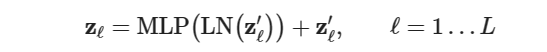

Here MLP is multilayer perceptron and LN is layer normalization.

In paper the structure is **MLP** contains 2 layers with **GELU** non-linearity.


In [ ]:
class MLPBlock(nn.Module):
    """Creates a layer normalized multilayer perceptron block ("MLP block" for short)."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 embedding_dim:int=768, # Hidden Size D from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 dropout:float=0.1): # Dropout from Table 3 for ViT-Base
        super().__init__()
        
        # 3. Create the Norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        
        # 4. Create the Multilayer perceptron (MLP) layer(s)
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim,
                      out_features=mlp_size),
            nn.GELU(), # "The MLP contains two layers with a GELU non-linearity (section 3.1)."
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size, # needs to take same in_features as out_features of layer above
                      out_features=embedding_dim), # take back to embedding_dim
            nn.Dropout(p=dropout) # "Dropout, when used, is applied after every dense layer.."
        )
    
    # 5. Create a forward() method to pass the data throguh the layers
    def forward(self, x):
        x = self.layer_norm(x)
        x = self.mlp(x)
        return x

Let's try it out on the an example


In [ ]:
# Create an instance of MLPBlock
mlp_block = MLPBlock(embedding_dim=768, # from Table 1 
                     mlp_size=3072, # from Table 1
                     dropout=0.1) # from Table 3

# Pass output of MSABlock through MLPBlock
patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)
print(f"Input shape of MLP block: {patched_image_through_mlp_block.shape}")
print(f"Output shape MLP block: {patched_image_through_mlp_block.shape}")

Input shape of MLP block: torch.Size([1, 197, 768])
Output shape MLP block: torch.Size([1, 197, 768])


### Transformer Encoder
Now let's create the transformer encoder by stacking MultiheadSelfAttentionBlock and MLPblock together.\
in DL encoder/auto-encoder generally referes to a stack of layers that encodes and input (turns it into some form of numerical information).\
In our case, the Transformer Encoder will encode our patched image embedding into a learned representation using a series of alternating layers of MSA blocks and MLP blocks, as per section 3.1 of the ViT Paper.\

Now we have to make residual connections. In our case residual connections means that the input of the MSA block is added back to the output of the MSA block before it passes to MLP block.\
in pseudocode:\
x_input -> MSA_block -> [MSA_block_output + x_input] -> MLP_block -> [MLP_block_output + MSA_block_output + x_input] -> ...

What it does is that they prevent weight values and gradient updates from getting too small and thus allow deeper networks and in turn allow deeper representations to be learned. for expample **ResNet**

In [ ]:

class TransformerEncoderBlock(nn.Module):
    """Creates a Transformer Encoder block."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 embedding_dim:int=768, # Hidden size D
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 mlp_dropout:float=0.1, # Amount of dropout for dense layers from Table 3 for ViT-Base
                 attn_dropout:float=0): # Amount of dropout for attention layers
        super().__init__()

        # 3. Create MSA block (equation 2)
        self.msa_block = MultiheadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                     num_heads=num_heads,
                                                     attn_dropout=attn_dropout)
        
        # 4. Create MLP block (equation 3)
        self.mlp_block =  MLPBlock(embedding_dim=embedding_dim,
                                   mlp_size=mlp_size,
                                   dropout=mlp_dropout)
        
    # 5. Create a forward() method  
    def forward(self, x):
        
        # 6. Create residual connection for MSA block (add the input to the output)
        x =  self.msa_block(x) + x 
        
        # 7. Create residual connection for MLP block (add the input to the output)
        x = self.mlp_block(x) + x 
        
        return x

For our case as given int the picture we've to stack L times the number of encoder blocks. for our particular case ViT-base we will stack 12 transformer encoder block together.
Let's have a look at the summary of our transfoerm encoder

In [ ]:
# Create an instance of TransformerEncoderBlock
transformer_encoder_block = TransformerEncoderBlock()

# Print an input and output summary of our Transformer Encoder (uncomment for full output)
summary(model=transformer_encoder_block,
        input_size=(1, 197, 768), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiheadSelfAttentionBlock (msa_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

### 8. Finally ViT
Finally putting it all toghether to create ViT
We will combine all the block we've created to replicate the full ViT architecture. From patch and positional encoding to transformer encoder to MLP head.


In [ ]:
class ViT(nn.Module):
    """Creates a Vision Transformer architecture with ViT-Base hyperparameters by default."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 img_size:int=224, # Training resolution from Table 3 in ViT paper
                 in_channels:int=3, # Number of channels in input image
                 patch_size:int=16, # Patch size
                 num_transformer_layers:int=12, # Layers from Table 1 for ViT-Base
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 attn_dropout:float=0, # Dropout for attention projection
                 mlp_dropout:float=0.1, # Dropout for dense/MLP layers 
                 embedding_dropout:float=0.1, # Dropout for patch and position embeddings
                 num_classes:int=1000): # Default for ImageNet but can customize this
        super().__init__() # don't forget the super().__init__()!
        
        # 3. Make the image size is divisble by the patch size 
        assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image size: {img_size}, patch size: {patch_size}."
        
        # 4. Calculate number of patches (height * width/patch^2)
        self.num_patches = (img_size * img_size) // patch_size**2
                 
        # 5. Create learnable class embedding (needs to go at front of sequence of patch embeddings)
        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                            requires_grad=True)
        
        # 6. Create learnable position embedding
        self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim),
                                               requires_grad=True)
                
        # 7. Create embedding dropout value
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)
        
        # 8. Create patch embedding layer
        self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                              patch_size=patch_size,
                                              embedding_dim=embedding_dim)
        
        # 9. Create Transformer Encoder blocks (we can stack Transformer Encoder blocks using nn.Sequential()) 
        # Note: The "*" means "all"
        self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                            num_heads=num_heads,
                                                                            mlp_size=mlp_size,
                                                                            mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])
       
        # 10. Create classifier head
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim, 
                      out_features=num_classes)
        )
    
    # 11. Create a forward() method
    def forward(self, x):
        
        # 12. Get batch size
        batch_size = x.shape[0]
        
        # 13. Create class token embedding and expand it to match the batch size (equation 1)
        class_token = self.class_embedding.expand(batch_size, -1, -1) # "-1" means to infer the dimension (try this line on its own)

        # 14. Create patch embedding (equation 1)
        x = self.patch_embedding(x)

        # 15. Concat class embedding and patch embedding (equation 1)
        x = torch.cat((class_token, x), dim=1)

        # 16. Add position embedding to patch embedding (equation 1) 
        x = self.position_embedding + x

        # 17. Run embedding dropout (Appendix B.1)
        x = self.embedding_dropout(x)

        # 18. Pass patch, position and class embedding through transformer encoder layers (equations 2 & 3)
        x = self.transformer_encoder(x)

        # 19. Put 0 index logit through classifier (equation 4)
        x = self.classifier(x[:, 0]) # run on each sample in a batch at 0 index

        return x       

In [ ]:
# Example of creating the class embedding and expanding over a batch dimension
batch_size = 32
class_token_embedding_single = nn.Parameter(data=torch.randn(1, 1, 768)) # create a single learnable class token
class_token_embedding_expanded = class_token_embedding_single.expand(batch_size, -1, -1) # expand the single learnable class token across the batch dimension, "-1" means to "infer the dimension"

# Print out the change in shapes
print(f"Shape of class token embedding single: {class_token_embedding_single.shape}") 
print(f"Shape of class token embedding expanded: {class_token_embedding_expanded.shape}")

Shape of class token embedding single: torch.Size([1, 1, 768])
Shape of class token embedding expanded: torch.Size([32, 1, 768])


In [ ]:
torch.cuda.manual_seed(42)

# Create a random tensor with same shape as a single image
random_image_tensor = torch.randn(1, 3, 224, 224) # (batch_size, color_channels, height, width)

# Create an instance of ViT with the number of classes we're working with (pizza, steak, sushi)
vit = ViT(num_classes=len(class_names))

# Pass the random image tensor to our ViT instance
vit(random_image_tensor)

tensor([[-0.0444,  0.5354, -0.3399]], grad_fn=<AddmmBackward0>)

In [ ]:
from torchinfo import summary

# # Print a summary of our custom ViT model using torchinfo
summary(model=vit, 
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                    [32, 3, 224, 224]    [32, 3]              152,064              True
├─PatchEmbedding (patch_embedding)                           [32, 3, 224, 224]    [32, 196, 768]       --                   True
│    └─Conv2d (patcher)                                      [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
│    └─Flatten (flatten)                                     [32, 768, 14, 14]    [32, 768, 196]       --                   --
├─Dropout (embedding_dropout)                                [32, 197, 768]       [32, 197, 768]       --                   --
├─Sequential (transformer_encoder)                           [32, 197, 768]       [32, 197, 768]       --                   True
│    └─TransformerEncoderBlock (0)                           [32, 197, 768]       [32, 197, 768]

### 9. Training
Now the time has come to train our model.

**optimizer** Adam - torch.optim.Adam()
**loss function** - Crossentroyploss(torch.nn.CrossEntropyLoss()) as it is a multiclass problem.

In [ ]:
# Setup the optimizer to optimize our ViT model parameters using hyperparameters from the ViT paper 
optimizer = torch.optim.Adam(params=vit.parameters(), 
                             lr=3e-3, # Base LR from Table 3 for ViT-* ImageNet-1k
                             betas=(0.9, 0.999), # default values but also mentioned in ViT paper section 4.1 (Training & Fine-tuning)
                             weight_decay=0.3) # from the ViT paper section 4.1 (Training & Fine-tuning) and Table 3 for ViT-* ImageNet-1k

# Setup the loss function for multi-class classification
loss_fn = torch.nn.CrossEntropyLoss()

# Set the seeds
torch.cuda.manual_seed(42)

# Train the model and save the training results to a dictionary
results = train(model=vit,
                train_dataloader=train_dataloader,
                test_dataloader=test_dataloader,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=30,
                device=device)

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.5274 | train_acc: 0.4062 | test_loss: 2.7658 | test_acc: 0.5417
Epoch: 2 | train_loss: 1.9942 | train_acc: 0.2930 | test_loss: 1.0589 | test_acc: 0.5417
Epoch: 3 | train_loss: 1.1382 | train_acc: 0.2852 | test_loss: 1.3240 | test_acc: 0.1979
Epoch: 4 | train_loss: 1.1596 | train_acc: 0.4062 | test_loss: 1.2827 | test_acc: 0.2604
Epoch: 5 | train_loss: 1.1561 | train_acc: 0.4141 | test_loss: 1.0381 | test_acc: 0.5417
Epoch: 6 | train_loss: 1.2299 | train_acc: 0.3516 | test_loss: 1.4888 | test_acc: 0.2604
Epoch: 7 | train_loss: 1.2269 | train_acc: 0.4414 | test_loss: 1.3318 | test_acc: 0.1979
Epoch: 8 | train_loss: 1.3761 | train_acc: 0.2617 | test_loss: 1.1373 | test_acc: 0.1979
Epoch: 9 | train_loss: 1.1561 | train_acc: 0.3164 | test_loss: 1.2621 | test_acc: 0.1979
Epoch: 10 | train_loss: 1.1754 | train_acc: 0.2891 | test_loss: 1.0454 | test_acc: 0.5417
Epoch: 11 | train_loss: 1.0916 | train_acc: 0.3477 | test_loss: 1.3397 | test_acc: 0.1979
Epoch: 12 | train_l

As can be seen above from the results our results are not satisfactory and good enough One reason could be that we used the base ViT which is about 85million parameters and our dataset is comparatively smaller. Also batch size differs substatially(32 used).

Let's see our loss curves.

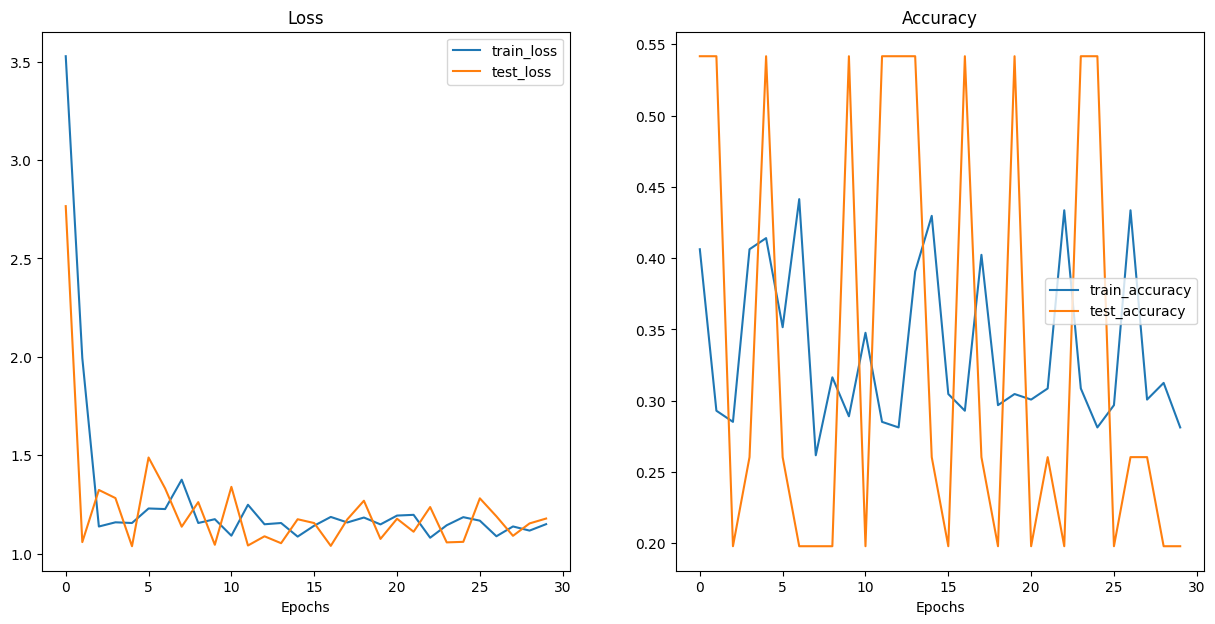

In [ ]:
plot_loss_curves(results)

Seems like our model is all over the place. It is because of the data we have and the structure of our ViT.


### pretrained ViT
Now, let's see we can improve our results or not. For that we've to use a pretrained model from *torchvision.models* on same dataset.\
One reason to use that is we've small dataset and limited computing resources, Better results in the paper is found maybe because of the larged computing resources and the datasets used by the researchers.

In [ ]:
# The following requires torch latest version
import torch
import torchvision
print(torch.__version__) 
print(torchvision.__version__)
from torch import nn

2.0.0+cu118
0.15.1+cu118


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

Finally we will get Pretrained ViT-Base with patch size 16 from torchvision.models and prepare it for foodvisionmini use case by turning it feature extractor transfer learning model.

Here specifically we will:
- Getting the pretrained weights for Vit-Base trained on ImageNet-1k.
- Setup a ViT model instance via torchvision.models.vit_b_16, pass it the pretrained weights step 1 and send it to the target device.
- Freeze all the parameters in ViT base model created to prevent the learning bu putting require_grad as False.
- Update the classifier head of the ViT model to suit our classes needs which is 3 in our case.   

In [ ]:
# 1. Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT #"DEFAULT" means best available

# 2. Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# 3. Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False
    
# 4. Change the classifier head (set the seeds to ensure same initialization with linear head)
torch.manual_seed(42)
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)
# pretrained_vit # uncomment for model output

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:02<00:00, 171MB/s]


In [ ]:
# Get automatic transforms from pretrained ViT weights
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [ ]:
# Setup dataloaders
train_dataloader_pretrained, test_dataloader_pretrained, class_names = create_dataloaders(train_dir=train_dir,
                                                                                          test_dir=test_dir,
                                                                                          transform=pretrained_vit_transforms,
                                                                                          batch_size=32) # Could increase if we had more samples, such as here: https://arxiv.org/abs/2205.01580 (there are other improvements there too...)


In [ ]:
# Print a summary using torchinfo
summary(model=pretrained_vit, 
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

/usr/local/lib/python3.9/dist-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
/usr/local/lib/python3.9/dist-packages/torch/storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 3]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

In [ ]:
# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(), 
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()
torch.manual_seed(42)
pretrained_vit_results = train(model=pretrained_vit,
                               train_dataloader=train_dataloader_pretrained,
                               test_dataloader=test_dataloader_pretrained,
                               optimizer=optimizer,
                               loss_fn=loss_fn,
                               epochs=20,
                               device=device)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7665 | train_acc: 0.7227 | test_loss: 0.5432 | test_acc: 0.8665
Epoch: 2 | train_loss: 0.3428 | train_acc: 0.9453 | test_loss: 0.3263 | test_acc: 0.8977
Epoch: 3 | train_loss: 0.2064 | train_acc: 0.9531 | test_loss: 0.2707 | test_acc: 0.9081
Epoch: 4 | train_loss: 0.1556 | train_acc: 0.9570 | test_loss: 0.2422 | test_acc: 0.9081
Epoch: 5 | train_loss: 0.1246 | train_acc: 0.9727 | test_loss: 0.2279 | test_acc: 0.8977
Epoch: 6 | train_loss: 0.1216 | train_acc: 0.9766 | test_loss: 0.2129 | test_acc: 0.9280
Epoch: 7 | train_loss: 0.0938 | train_acc: 0.9766 | test_loss: 0.2352 | test_acc: 0.8883
Epoch: 8 | train_loss: 0.0797 | train_acc: 0.9844 | test_loss: 0.2281 | test_acc: 0.8778
Epoch: 9 | train_loss: 0.1098 | train_acc: 0.9883 | test_loss: 0.2074 | test_acc: 0.9384
Epoch: 10 | train_loss: 0.0650 | train_acc: 0.9883 | test_loss: 0.1804 | test_acc: 0.9176
Epoch: 11 | train_loss: 0.0623 | train_acc: 0.9922 | test_loss: 0.1846 | test_acc: 0.9176
Epoch: 12 | train_l

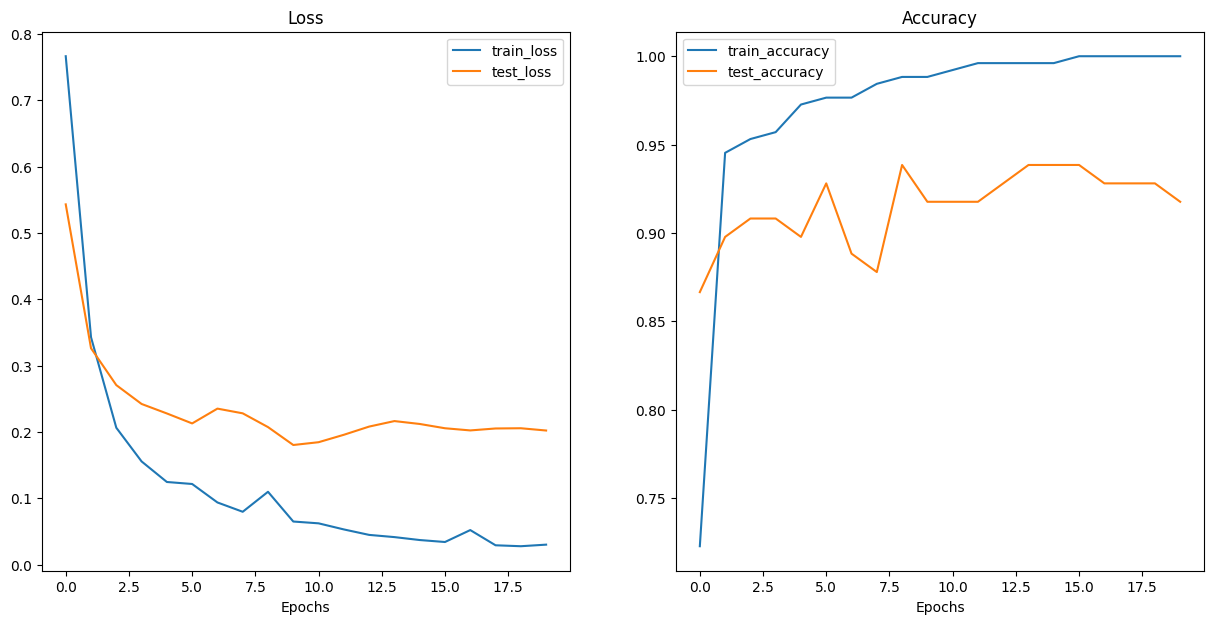

In [ ]:
# Plot the loss curves

plot_loss_curves(pretrained_vit_results) 

saving the model

In [ ]:
# Save the model

save_model(model=pretrained_vit,
           target_dir="models",
           model_name="08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth")

[INFO] Saving model to: models/08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth


knowing the size


In [ ]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_vit_model_size = Path("models/08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth").stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly) 
print(f"Pretrained ViT feature extractor model size: {pretrained_vit_model_size} MB")

Pretrained ViT feature extractor model size: 327 MB


### 9 Predicting of Random Images

Here are some example of our model on some images taken on random.

In [ ]:
import torch
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt

from typing import List, Tuple

from PIL import Image

# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Predict on a target image with a target model
# Function created in: https://www.learnpytorch.io/06_pytorch_transfer_learning/#6-make-predictions-on-images-from-the-test-set
def pred_and_plot_image(
    model: torch.nn.Module,
    class_names: List[str],
    image_path: str,
    image_size: Tuple[int, int] = (224, 224),
    transform: torchvision.transforms = None,
    device: torch.device = device,
):
    """Predicts on a target image with a target model.
    Args:
        model (torch.nn.Module): A trained (or untrained) PyTorch model to predict on an image.
        class_names (List[str]): A list of target classes to map predictions to.
        image_path (str): Filepath to target image to predict on.
        image_size (Tuple[int, int], optional): Size to transform target image to. Defaults to (224, 224).
        transform (torchvision.transforms, optional): Transform to perform on image. Defaults to None which uses ImageNet normalization.
        device (torch.device, optional): Target device to perform prediction on. Defaults to device.
    """

    # Open image
    img = Image.open(image_path)

    # Create transformation for image (if one doesn't exist)
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose(
            [
                transforms.Resize(image_size),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
                ),
            ]
        )

    ### Predict on image ###

    # Make sure the model is on the target device
    model.to(device)

    # Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
        # Transform and add an extra dimension to image (model requires samples in [batch_size, color_channels, height, width])
        transformed_image = image_transform(img).unsqueeze(dim=0)

        # Make a prediction on image with an extra dimension and send it to the target device
        target_image_pred = model(transformed_image.to(device))

    # Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # Plot image with predicted label and probability
    plt.figure()
    plt.imshow(img)
    plt.title(
        f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}"
    )
    plt.axis(False)

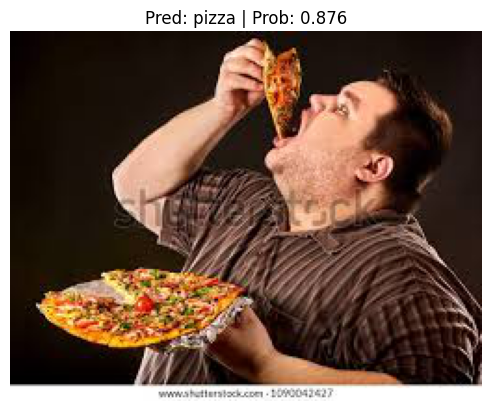

In [ ]:
import requests

# Setup custom image path
custom_image_path = "/content/data/random images/pizza.jfif"

# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)

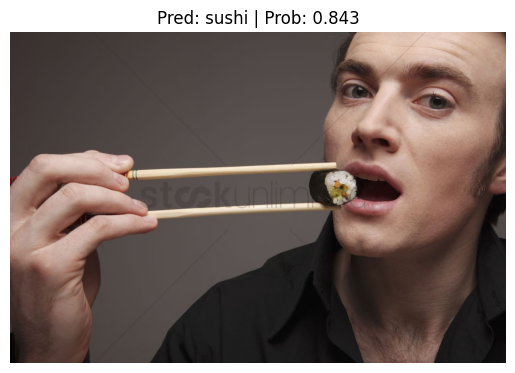

In [ ]:
path = "/content/data/random images/man-eating-sushi-with-chopsticks_1848746.jpg"
pred_and_plot_image(model=pretrained_vit,
                    image_path=path,
                    class_names=class_names)

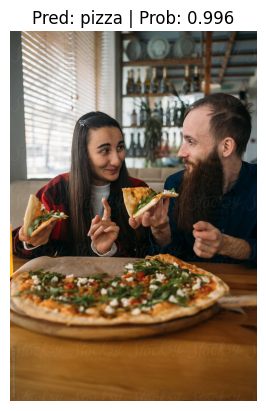

In [ ]:
path = "/content/data/random images/pizza.jpg"
pred_and_plot_image(model=pretrained_vit,
                    image_path=path,
                    class_names=class_names)

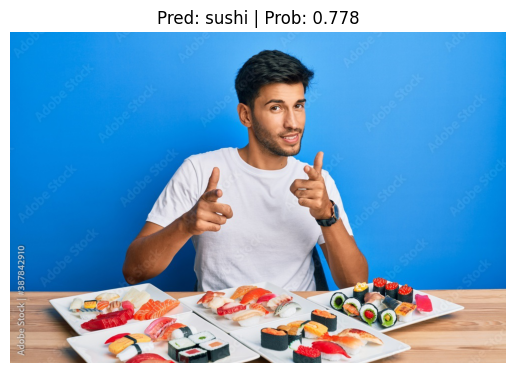

In [ ]:
path = "/content/data/random images/sushi.jpg"
pred_and_plot_image(model=pretrained_vit,
                    image_path=path,
                    class_names=class_names)

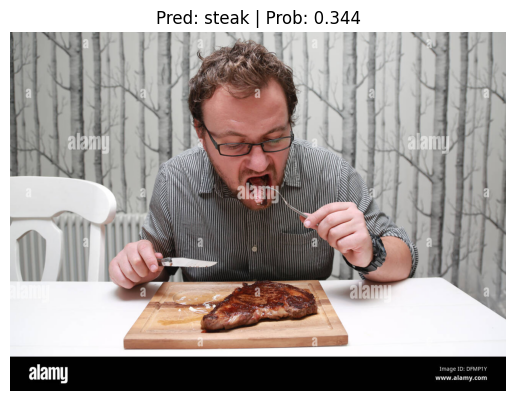

In [ ]:
path = "/content/data/random images/steak2.jpg"
pred_and_plot_image(model=pretrained_vit,
                    image_path=path,
                    class_names=class_names)

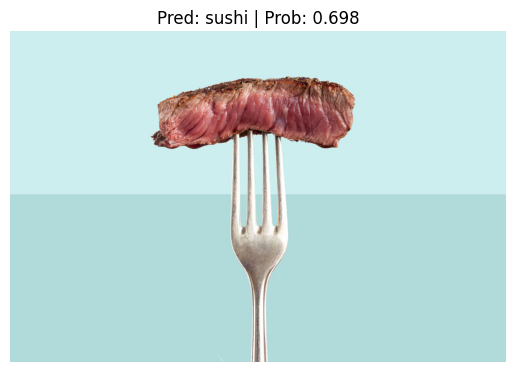

In [ ]:
path = "/content/data/random images/piecesteak.jpg"
pred_and_plot_image(model=pretrained_vit,
                    image_path=path,
                    class_names=class_names)

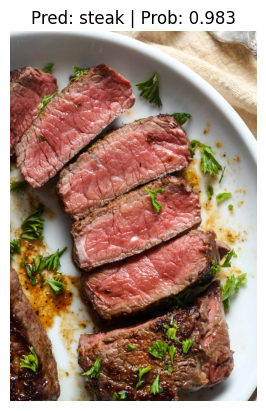

In [ ]:
path = "/content/data/random images/steak3.jpeg"
pred_and_plot_image(model=pretrained_vit,
                    image_path=path,
                    class_names=class_names)

Seems like our model is preforming well with pretrained model it has some problem predicting the steak maybe because it cannot see inside 

## EfficinetB0(CNN pretrained model)
*torchvision.models.efficient_b0():\
Here we're going to create a pretrained EfficientNet_B0 model from torchvision.models with the output layer adjusted for our use case of classifying pizza, steak and sushi images.\
Note : Dropout layers randomly remove connections between two neural network layers with a probability of p. For example, if p=0.2, 20% of connections between neural network layers will be removed at random each pass. This practice is meant to help regularize (prevent overfitting) a model by making sure the connections that remain learn features to compensate for the removal of the other connections (hopefully these remaining features are more general).

In [10]:
import torchvision
from torchinfo import summary

# 1. Create an instance of EffNetB2 with pretrained weights
effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT # "DEFAULT" means best available weights
effnetb2 = (torchvision.models.efficientnet_b2(weights=effnetb2_weights))

# # 2. Get a summary of standard EffNetB2 from torchvision.models (uncomment for full output)
# summary(model=effnetb2, 
#         input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
#         # col_names=["input_size"], # uncomment for smaller output
#         col_names=["input_size", "output_size", "num_params", "trainable"],
#         col_width=20,
#         row_settings=["var_names"]
# ) 

# 3. Get the number of in_features of the EfficientNetB2 classifier layer
print(f"Number of in_features to final layer of EfficientNetB2: {len(effnetb2.classifier.state_dict()['1.weight'][0])}")

Number of in_features to final layer of EfficientNetB2: 1408


In [14]:
def create_effnetb0():
    # 1. Get the base mdoel with pretrained weights and send to target device
    weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
    model = torchvision.models.efficientnet_b0(weights=weights).to(device)

    # 2. Freeze the base model layers
    for param in model.features.parameters():
        param.requires_grad = False

    # 3. Set the seeds
    torch.manual_seed(42)

    # 4. Change the classifier head
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.2),
        nn.Linear(in_features=1280, out_features=3)
    ).to(device)

    # 5. Give the model a name
    model.name = "effnetb0"
    print(f"[INFO] Created new {model.name} model.")
    return model

In [15]:
effnetb0 = create_effnetb0()  # instantiating a model

[INFO] Created new effnetb0 model.


In [21]:
effnet_results = train(model=effnetb0,  # training on the model
                      train_dataloader=train_dataloader,  # train dataloader
                      test_dataloader=test_dataloader,   # test dataloader
                      optimizer=torch.optim.Adam(params=effnetb0.parameters()),  # adam optimizer
                      loss_fn=nn.CrossEntropyLoss(),  # loss function as CrossEntroyLoss
                      epochs=20,  # number of epochs
                      device=device  # GPU/CPU
)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.3592 | train_acc: 0.8281 | test_loss: 0.3751 | test_acc: 0.9489
Epoch: 2 | train_loss: 0.3229 | train_acc: 0.9688 | test_loss: 0.3333 | test_acc: 0.9176
Epoch: 3 | train_loss: 0.3475 | train_acc: 0.8398 | test_loss: 0.3172 | test_acc: 0.8864
Epoch: 4 | train_loss: 0.3369 | train_acc: 0.8281 | test_loss: 0.3246 | test_acc: 0.9072
Epoch: 5 | train_loss: 0.2624 | train_acc: 0.9766 | test_loss: 0.3231 | test_acc: 0.9384
Epoch: 6 | train_loss: 0.4038 | train_acc: 0.8477 | test_loss: 0.3731 | test_acc: 0.9384
Epoch: 7 | train_loss: 0.3106 | train_acc: 0.8594 | test_loss: 0.3058 | test_acc: 0.9176
Epoch: 8 | train_loss: 0.3201 | train_acc: 0.8477 | test_loss: 0.2995 | test_acc: 0.9280
Epoch: 9 | train_loss: 0.2933 | train_acc: 0.9609 | test_loss: 0.3055 | test_acc: 0.9072
Epoch: 10 | train_loss: 0.2748 | train_acc: 0.9648 | test_loss: 0.2972 | test_acc: 0.9072
Epoch: 11 | train_loss: 0.3955 | train_acc: 0.8164 | test_loss: 0.3042 | test_acc: 0.9072
Epoch: 12 | train_l

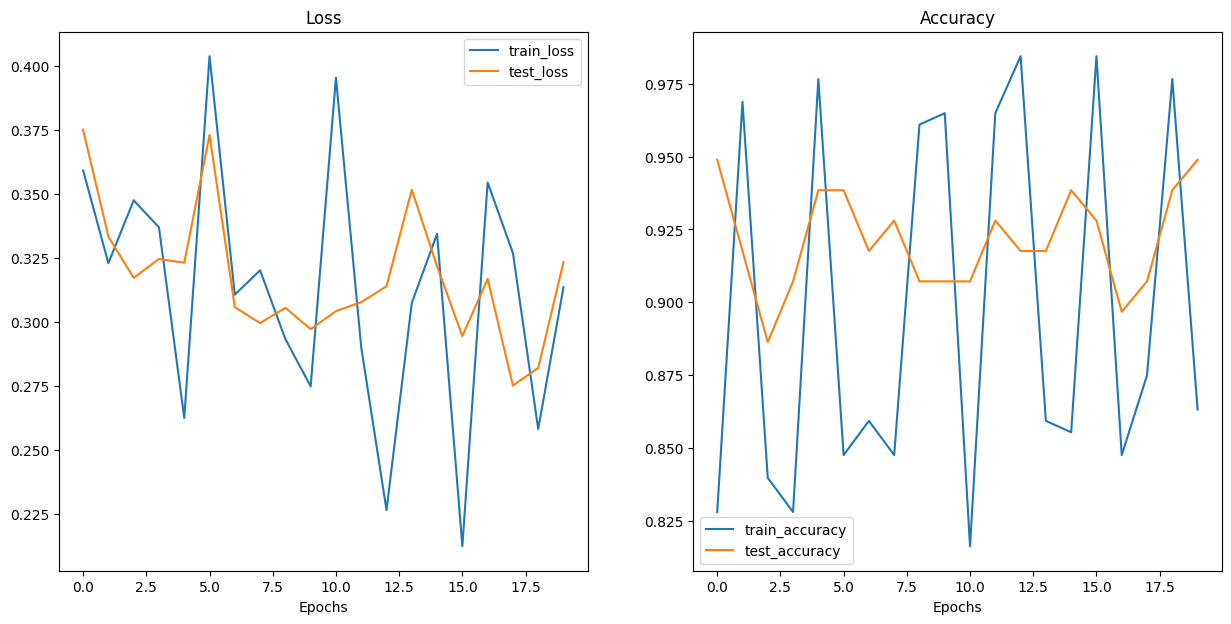

In [22]:
plot_loss_curves(effnet_results) # Plotting of loss and Accuracy curves

## Conclusion
Here we tried replicating the paper [An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale](https://arxiv.org/abs/2010.11929).
We went on with everything that was mentioned in paper(except for some) and replicated the ViT-Base model with 85 million parameter. Now we tested it on the little data we had which is foodvisionMini dataset. Our performances were not as good as it was on paper for that our explnation is that our architecture might be little bit differnt from what was implement in the paper(like the batch size, posionining of Norm layers etc). So we went on and use pretrained Vit-Base from torchvision.models and implement transfer learning and our results were good, we reached the test accuracy of 91 percent and our model is able to predict the food images fairly well. Only problem this is having is in predicting the **steak** in some images. But rest are fair enough. 
Then we tried using a pretrained light CNN model to have a prediction on it and we got fairly small difference only in CNN model the fluctuation of accuracy and losses were more significant. But overall accuracy came out to be same.
